Authors: @Arto, @hallvagi

In [1]:
from fastai.text.all import *
from torch.utils.data import Dataset
sys.path.append("..")
from basic_transformer import TransformerLM
torch.cuda.set_device(3)

Explore the synthetic task explained in table 2 of the reformer paper: 

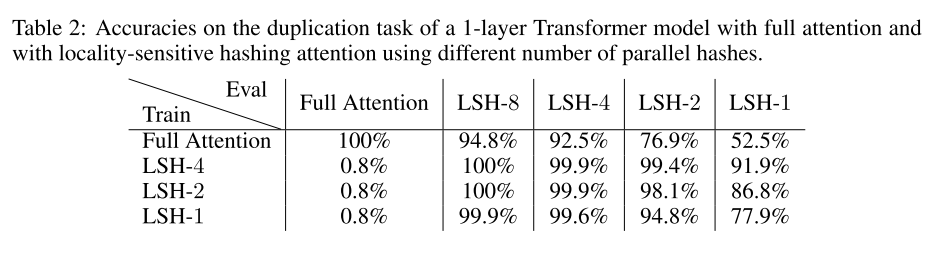

TODO:
* Implement ReformerLM
* Switch model from train to eval. Can do with load wts? 

# Create dataset

We create items on the fly instead of all items up front. We return a tuple to make the dataloader a bit easier to inspect.

In [2]:
class TwinSequence(Dataset):
    def __init__(self, sl=1024, len=100):
        assert sl%2 == 0
        self.sl = sl
        self.len = len
    def __getitem__(self, idx):
        seq = torch.randint(1,128,(self.sl//2,))             # w: [1-127] of len sl//2
        seq[0] = 0                                           # seq = 0w
        seq = torch.cat((seq,seq), -1)                       # seq = 0w0w
        target = torch.cat((seq[1:],torch.tensor([0])), -1)  # return offset target x:[0123], y:[1230]
        return (seq, target)                     
    def __len__(self):
        return self.len

In [3]:
dls = DataLoaders.from_dsets(TwinSequence(10, 50), bs=6, shuffle=False, device='cuda')
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([6, 10]), torch.Size([6, 10]))

Note that the final target item is a padded 0. But that should also be predicitable from the first part of the input sequence:

In [4]:
xb[0].tolist(), yb[0].tolist()

([0, 8, 108, 116, 68, 0, 8, 108, 116, 68],
 [8, 108, 116, 68, 0, 8, 108, 116, 68, 0])

In [5]:
xb.shape

torch.Size([6, 10])

The number of batches in train data loader (`n_iter` in fastai lingo): The reformer paper mentions 150 k steps. One step is one iteration/batches.

In [6]:
len(dls.train)

8

## Target masking

We have to mask the **first half** of the targets. The first part is just random integers, so it's impossible to learn anything from it. We set the tokens in the first part to a special index, -100, and later tell our lossfunction to ignore items with this value. This means that the only task the model can learn is to copy the first part of the input sequence. If we didn't mask the first part, it would be penalized for poor performance in the first part, and would try to find a compromise.

In [7]:
class MaskTargCallback(Callback):
    def before_batch(self):
        self.y[:, :self.dls.train_ds.sl//2] = -100

We create a custom accuracy that also disregards tokens with value -100:

In [8]:
def masked_accuracy(inp, targ, ignore=-100):
    pred = inp.argmax(dim=-1)
    mask = targ[0] != ignore
    return (pred[:,mask] == targ[:,mask]).float().mean()

In [9]:
pred = torch.tensor([   0,   1,   2,   3,   4,1,2,3,4,55])[None,:]
targ = torch.tensor([-100,-100,-100,-100,-100,1,2,3,4,0])[None,:]
mask = targ[0] != -100
(pred[:,mask] == targ[:,mask]).float().mean()

tensor(0.8000)

And finally a callback to inspect items directly before modelling:

In [10]:
class Inspect_items(Callback):
    def after_batch(self):
        if self.iter==0 and self.epoch==0 and self.training:
            inp = self.learn.x[0].tolist()
            targ = self.learn.y[0].tolist()
            df = pd.DataFrame((inp,targ)).T
            df.columns = ['inp', 'targ']
            print(df)

# Inspect masking

Let's check what's actually going into the model:

In [11]:
bs, sl = 64,16
n_epochs = 1
train_sz = 500
valid_sz = 100

In [12]:
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')

model = TransformerLM(128, 256, d_ff=256, n_layers=1, heads=4, max_seq_len=sl, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback(), Inspect_items()])

In [13]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.653862,4.551935,0.125000,00:02


    inp  targ
0     0  -100
1    81  -100
2   123  -100
3   100  -100
4    96  -100
5    91  -100
6     1  -100
7    82  -100
8     0    81
9    81   123
10  123   100
11  100    96
12   96    91
13   91     1
14    1    82
15   82     0


# Short sequence modelling

In [14]:
bs, sl = 64,64
n_epochs = 10
train_sz = 50_000
valid_sz = 10_000

In [15]:
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')

model = TransformerLM(128, 256, d_ff=256, n_layers=1, heads=4, max_seq_len=sl, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback()])

Total training steps:

In [16]:
len(dls.train)*n_epochs

7810

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.00363078061491251)

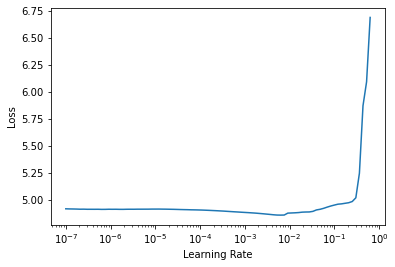

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(n_epochs, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,0.342628,0.057139,0.999369,00:17
1,0.006607,0.007663,0.998119,00:17
2,0.003563,0.004465,0.999097,00:19
3,0.002813,0.001425,0.999784,00:20
4,0.001340,0.001207,0.999788,00:19
5,0.000408,0.000545,0.999919,00:19
6,0.000138,0.000160,0.999975,00:21
7,0.000010,0.000009,1.000000,00:19
8,0.000007,0.000007,1.000000,00:17
9,0.000007,0.000007,1.000000,00:20


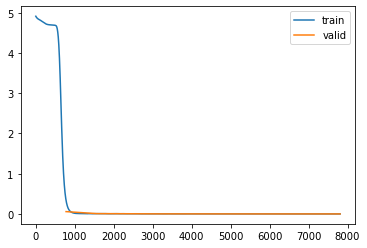

In [19]:
learn.recorder.plot_loss()

## Test inference and visualise attention

In [66]:
x = dls.train_ds[0][0].cuda()
x = x[None]
x[:,x.size(1)//2+1:]

tensor([[ 92,  64,  97,  94,  17, 109, 108,  37,  90,  60, 112,  79, 117,  35,
         102, 104, 105,  33,  25, 106,  11, 107,  43,  90,  13,  61,  52,  56,
         102,  20,  41]], device='cuda:3')

In [67]:
learn.model.store_attention()
with torch.no_grad():
    out = learn.model(x[:,:-1])

preds = out.argmax(-1)[:,x.size(1)//2:]
(preds == x[:,x.size(1)//2+1:]).float().mean()

tensor(1., device='cuda:3')

In [68]:
attn = learn.model.get_attention_matrix()

We have 4 layers in our transformer, and 1 attention matrix per layer:
**Note**: Why only 63 tokens in attention?

In [72]:
attn[0].shape

torch.Size([1, 4, 63, 63])

> **The attention matrices shows us that mid way through the sequence the model starts paying attention to the first input sequence as expected. Each layers learns a bit different, but the combined output is good enough for perfect sequence copying. Note that there is no pattern to learn before this point, so the attention is just random noise. We also see that no token peeks ahead of it's own location**

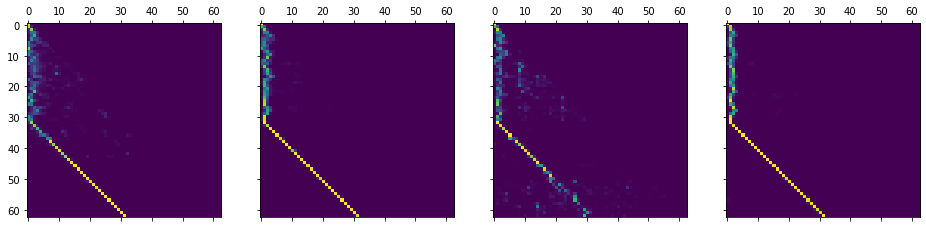

In [73]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 16))
for ax, mat in zip(axs, attn[0][0]):
    ax.matshow(mat)

# Long sequence modelling

Higher batch sizes gives out of memory error.

In [15]:
bs, sl = 64,1024
n_epochs = 10
train_sz = 50_000
valid_sz = 10_000

In [16]:
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')

model = TransformerLM(128, 256, d_ff=256, n_layers=1, heads=4, max_seq_len=sl, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback()])

Total training steps:

In [17]:
len(dls.train)*n_epochs

7810

In [18]:
learn.fit_one_cycle(n_epochs, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.835723,4.835759,0.009760,01:33
1,4.837259,4.835764,0.009777,01:33
2,0.041859,0.003960,0.999995,01:34
3,0.000792,0.000480,0.999929,01:33
4,0.000243,0.000146,0.999979,01:34
5,0.000174,0.000189,0.999968,01:33
6,0.000046,0.000026,0.999997,01:33
7,0.000008,0.000008,1.000000,01:33
8,0.000007,0.000007,1.000000,01:33
9,0.000007,0.000007,1.000000,01:33


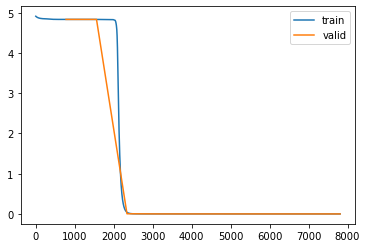

In [19]:
learn.recorder.plot_loss()